# Training: Classical case

## Preparation

We start with importing PyTorch and specifying some training hyperparameters.

In [1]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

### Input data

Let's read the data and print some example sentences.

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../examples/datasets/mc_train_data.txt')
val_labels, val_data = read_data('../examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/mc_test_data.txt')

In [3]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

Targets are represented as 2-dimensional arrays:

In [4]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

### Creating and parameterising diagrams

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

train_diagrams = parser.sentences2diagrams(train_data)
val_diagrams = parser.sentences2diagrams(val_data)
test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


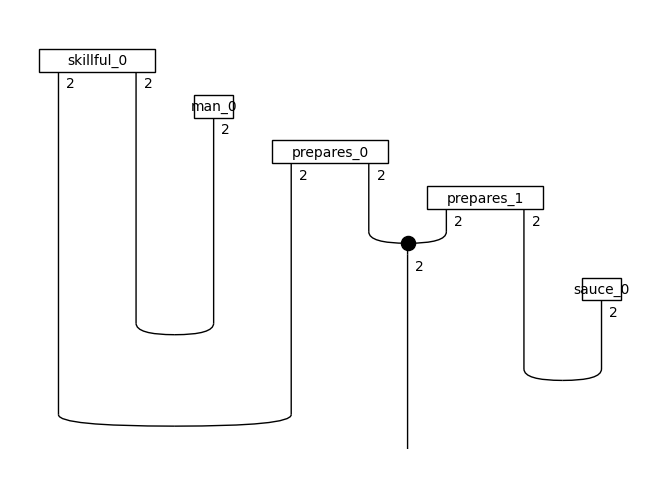

In [6]:
from discopy.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

## Training

### Instantiate model

In [7]:
from lambeq import PytorchModel

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

### Define evaluation metric

Optionally, we can provide a dictionary of callable evaluation metrics with the signature ``metric(y_hat, y)``.

In [8]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

### Initialise trainer

In [9]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

### Create datasets

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [11]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=5)

TypeError: Cannot interpret 'torch.float32' as a data type

## Results

Finally, we visualise the results and evaluate the model on the test data.

Test accuracy: 0.9833333492279053


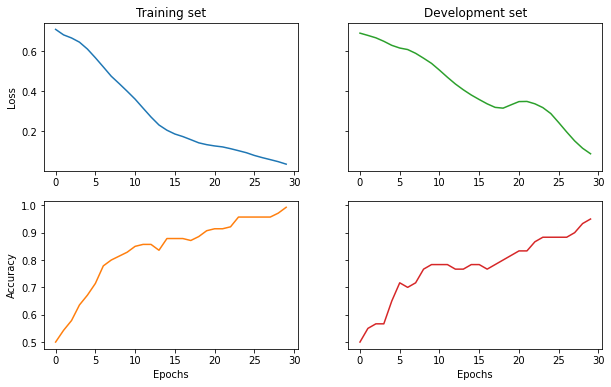

In [ ]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())

## Adding custom layers to the model

In [ ]:
class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds)
        return preds

The rest follows the same procedure as explained above, i.e. initialise a trainer, fit the model and visualise the results.

In [ ]:
custom_model = MyCustomModel.from_diagrams(all_circuits)
custom_model_trainer = PytorchTrainer(
        model=custom_model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)
custom_model_trainer.fit(train_dataset, val_dataset, logging_step=5)

Epoch 1:   train/loss: 0.7148   valid/loss: 0.6871   train/acc: 0.4143   valid/acc: 0.5833
Epoch 5:   train/loss: 0.4211   valid/loss: 0.5144   train/acc: 0.8714   valid/acc: 0.8167
Epoch 10:  train/loss: 0.2201   valid/loss: 0.3550   train/acc: 0.9714   valid/acc: 0.9000
Epoch 15:  train/loss: 0.1201   valid/loss: 0.3603   train/acc: 1.0000   valid/acc: 0.9667
Epoch 20:  train/loss: 0.0426   valid/loss: 0.4961   train/acc: 1.0000   valid/acc: 0.9500
Epoch 25:  train/loss: 0.0073   valid/loss: 0.6688   train/acc: 1.0000   valid/acc: 0.9000
Epoch 30:  train/loss: 0.0018   valid/loss: 0.8141   train/acc: 1.0000   valid/acc: 0.9000

Training completed!


Test accuracy: 0.9833333492279053


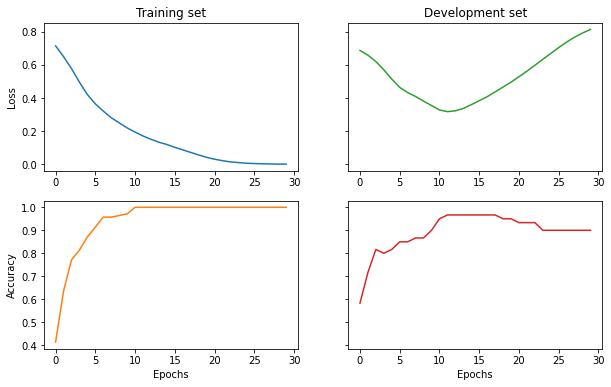

In [ ]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(custom_model_trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(custom_model_trainer.train_results['acc'], color=next(colours))
ax_tr.plot(custom_model_trainer.val_costs, color=next(colours))
ax_br.plot(custom_model_trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())